# NLP Project Anaïs Malet : Predict TripAdvisor Reviews Rating 

### Content

This dataset consisting of 20k reviews crawled from Tripadvisor.

### Goal

The whole goal of the project is to predict how many stars gets a hotel based on client reviews.

### Credits

Tripadvisor Hotel Review Dataset file, from the publication:

Alam, M. H., Ryu, W.-J., Lee, S., 2016. Joint multi-grain topic senti- ment: modeling semantic aspects for online reviews. Information Sci- ences 339, 206–223.

## Notebook 3 : Improve the model baseline

In [4]:
# Import librairies
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
import tensorflow.compat.v1 as tf
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
pd.options.mode.chained_assignment = None

## Load and read data


In [5]:
df = pd.read_csv("tripadvisor_hotel_reviews.csv")
print(f"Number of rows : {df.shape[0]}\nNumber of columns : {df.shape[1]}")
df

Number of rows : 20491
Number of columns : 2


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


## ***Train/test split***

### Encoding labels

We want to encode the class labels and create a train/test split

In [6]:
# instantiate a label encoder # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
label_encoder = LabelEncoder()

# fit and transform the encoder on labels
df['Review_enc'] = label_encoder.fit_transform(df['Rating'])

### Split arrays or matrices into random train and test subsets.

In [7]:
# Define class labels
class_labels = ["1 star","2 stars","3 stars","4 stars","5 stars"]
category_orders = {"Review": class_labels}

# Split the data into training and testing sets
X = df['Review']
y = df['Review_enc']

## 1. Weighting of classes

Some algorithms we tested in previous notebook allow additional weight to be given to classes less represented during training, to compensate for the imbalanced classes dataset. 
Let's try to implement weights, for example with class_weight='balanced'.

### Split dataset

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Add weights to models attributes

In [13]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier

# For XGBoost params
minority_classes = [1, 2, 3]
scale_pos_weight = sum([sum(y_train == i) for i in minority_classes]) / len(minority_classes)

models = {
    'SVC': {'model': SVC(random_state=42, class_weight='balanced')},
    'LogisticRegression': {'model': LogisticRegression(class_weight='balanced')},
    'RandomForest': {'model': RandomForestClassifier(random_state=42, class_weight='balanced')},
    'DecisionTree': {'model': DecisionTreeClassifier(random_state=42, class_weight='balanced')},
    'KNN_Weighted': {'model': KNeighborsClassifier(weights='distance')},
    'SGDClassifier': {'model': SGDClassifier(random_state=42, class_weight='balanced')},
    'XGBoost': {'model': XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight)},
}

vectorizers = {
    'BoW': {'vectorizer': CountVectorizer()},
    'TF-IDF': {'vectorizer': TfidfVectorizer()},
}

### Let's loop over classifiers and vectorizer to find the best improved pipeline !

In [14]:
best_model = None
best_score = 0
best_vectorizer = None

for model_name, model_data in models.items():
    for vectorizer_name, vectorizer_data in vectorizers.items():
        vectorizer = vectorizer_data['vectorizer']
        model = model_data['model']
        
        pipeline = Pipeline([
            ('Vectorize', vectorizer),
            ('Model', model)
        ])
        
        print('Vectorizer: ', vectorizer_name),
        print('Model: ', model_name)

        pipeline.fit(X_train, y_train)

        print(f'accuracy_score: {accuracy_score(y_test, pipeline.predict(X_test))}\n')

        if pipeline.score(X_test, y_test) > best_score:
            best_score = pipeline.score(X_test, y_test)
            best_model = model_name
            best_vectorizer = vectorizer_name
            best_pipeline = pipeline

print(f'Best model: {best_model}')
print(f'Best vectorizer: {best_vectorizer}')

best_pipeline.fit(X_train, y_train)

print(f'accuracy_score: {accuracy_score(y_test, best_pipeline.predict(X_test))}\n')
print(f'Classification Report:\n{classification_report(y_test, best_pipeline.predict(X_test))}')
confusion_matrix_f = confusion_matrix(y_test, best_pipeline.predict(X_test))
# styling the confusion matrix
fig = px.imshow(
    confusion_matrix_f, 
    text_auto=True, 
    title="Confusion Matrix", width=1000, height=800,
    labels=dict(x="Predicted", y="True Label"),
    x=class_labels,
    y=class_labels,
    color_continuous_scale='Blues'  
    )
fig.show()

Vectorizer:  BoW
Model:  SVC
accuracy_score: 0.6060014637716516

Vectorizer:  TF-IDF
Model:  SVC
accuracy_score: 0.6350329348621615

Vectorizer:  BoW
Model:  LogisticRegression


/Users/mac/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy_score: 0.5898999756038058

Vectorizer:  TF-IDF
Model:  LogisticRegression


/Users/mac/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy_score: 0.6177116369846304

Vectorizer:  BoW
Model:  RandomForest
accuracy_score: 0.5093925347645767

Vectorizer:  TF-IDF
Model:  RandomForest
accuracy_score: 0.5137838497194438

Vectorizer:  BoW
Model:  DecisionTree
accuracy_score: 0.4505977067577458

Vectorizer:  TF-IDF
Model:  DecisionTree
accuracy_score: 0.4147353012929983

Vectorizer:  BoW
Model:  KNN_Weighted
accuracy_score: 0.46133203220297636

Vectorizer:  TF-IDF
Model:  KNN_Weighted
accuracy_score: 0.4974383996096609

Vectorizer:  BoW
Model:  SGDClassifier
accuracy_score: 0.5655037814101

Vectorizer:  TF-IDF
Model:  SGDClassifier
accuracy_score: 0.5933154427909246

Vectorizer:  BoW
Model:  XGBoost


/Users/mac/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:57:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


accuracy_score: 0.6028299585264699

Vectorizer:  TF-IDF
Model:  XGBoost


/Users/mac/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:57:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


accuracy_score: 0.5999024152232252

Best model: SVC
Best vectorizer: TF-IDF
accuracy_score: 0.6350329348621615

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.61      0.69       292
           1       0.44      0.52      0.48       333
           2       0.41      0.36      0.38       432
           3       0.55      0.60      0.57      1252
           4       0.77      0.75      0.76      1790

    accuracy                           0.64      4099
   macro avg       0.59      0.57      0.58      4099
weighted avg       0.64      0.64      0.64      4099



We still find SVC as the best pipeline model with an accuracy of 0.64, it even look like it was not better when we look in details ...

- Best model: SVC
- Best vectorizer: TF-IDF
- accuracy_score: 0.6350329348621615 < 0.64

This algorithmic like Logistic Regression classifier is known to handles well class imbalanced, maybe it didn't need attributes.

Let's continue to try our research !

## 2. Oversampling

We can increase the number of samples in underrepresented classes by replicating or creating synthetic data to balance the classes. 
However, this can lead to overfitting if the synthetic data does not accurately represent the real characteristics of the minority class.

When dealing with a multi-class imbalanced dataset, there are several oversampling techniques available in the imbalanced-learn library. Here are some of the commonly used oversampling methods along with a brief description:

- RandomOverSampler: Randomly duplicates instances of the minority class until the class distribution is balanced.
- SMOTE (Synthetic Minority Over-sampling Technique): Creates synthetic samples for the minority class by interpolating between existing instances.
- ADASYN (Adaptive Synthetic Sampling): Generates synthetic samples for the minority class with a focus on more challenging examples.

We can use SMOTE.

Unique Classes: {0, 1, 2, 3, 4}
Class=3, n=9054 (20.000%)
Class=1, n=9054 (20.000%)
Class=2, n=9054 (20.000%)
Class=4, n=9054 (20.000%)
Class=0, n=9054 (20.000%)


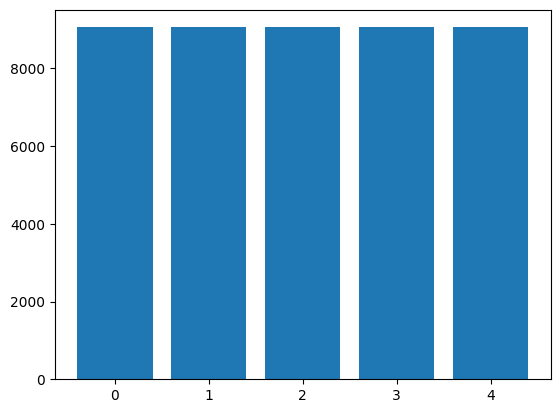

In [9]:
# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X)

# Define the unique classes present in your labels
unique_classes = set(y)  # Get the unique classes in the original labels

# Print or check the unique classes
print("Unique Classes:", unique_classes)

# Apply SMOTE without specifying the sampling strategy
oversample = SMOTE()
X_resampled, y_resampled = oversample.fit_resample(X_tfidf, y)

# summarize distribution
counter = Counter(y_resampled)
for k,v in counter.items():
 per = v / len(y_resampled) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()


### ***Improved_model Class Definition***

We create an improved class model with adding an attribute 'self.sampling' to handle undersampling or oversampling in the pipeline of our class.
This pipeline will take raw reviews as input, preprocess and vectorize them, before fitting an undersampling or oversampling model and then a classification model to it.
The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.

In [16]:
from Classes import Improved_model
from Preprocessing_functions import preprocess_text

### Model with LogisticRegression and TF-IDF but this time with oversampling with SMOTE

In [8]:
# instantiate the Model class with text and labels (X and y), a logistic regression model and a tfidf vectorizer
model_clf = Improved_model(X, y, LogisticRegression(class_weight='balanced', solver='liblinear'), TfidfVectorizer(preprocessor=preprocess_text),SMOTE(random_state=42), random_seed=42, test_size=0.2)

# fit the model
model_clf.fit()

# predict and generate classification report
model_clf.report(class_labels)

              precision    recall  f1-score   support

      1 star       0.66      0.68      0.67       292
     2 stars       0.37      0.46      0.41       333
     3 stars       0.35      0.40      0.37       432
     4 stars       0.55      0.45      0.50      1252
     5 stars       0.75      0.77      0.76      1790

    accuracy                           0.60      4099
   macro avg       0.53      0.55      0.54      4099
weighted avg       0.61      0.60      0.60      4099



In [17]:
# instantiate the Model class with text and labels (X and y), a logistic regression model and a tfidf vectorizer
model_clf = Improved_model(X, y, SVC(random_state=42), TfidfVectorizer(preprocessor=preprocess_text),SMOTE(random_state=42), random_seed=42, test_size=0.2)

# fit the model
model_clf.fit()

# predict and generate classification report
model_clf.report(class_labels)

              precision    recall  f1-score   support

      1 star       0.81      0.57      0.67       292
     2 stars       0.44      0.44      0.44       333
     3 stars       0.48      0.25      0.33       432
     4 stars       0.56      0.53      0.55      1252
     5 stars       0.71      0.85      0.77      1790

    accuracy                           0.64      4099
   macro avg       0.60      0.53      0.55      4099
weighted avg       0.62      0.64      0.62      4099



## 3. Undersampling 

To alleviate this class imbalance we can do undersampling :

We can randomly reduce the number of samples in over-represented classes to balance the classes. However, this may result in potential information loss.
Our dataset presents more than two classes and two of them are considered the majority, we can use specific techniques to handle this situation. The objective is to subsample these majority classes in order to balance the dataset.

The imbalanced-learn library provides options for handling multiple majority classes. The use of specific techniques depends on the situation and data. 
Here are some strategies:

- RandomUnderSampler
- ClusterCentroids
- TomekLinks

### Let's test undersampling with RandomUnderSampler

Unique Classes: {0, 1, 2, 3, 4}
Class=0, n=1421 (20.000%)
Class=1, n=1421 (20.000%)
Class=2, n=1421 (20.000%)
Class=3, n=1421 (20.000%)
Class=4, n=1421 (20.000%)


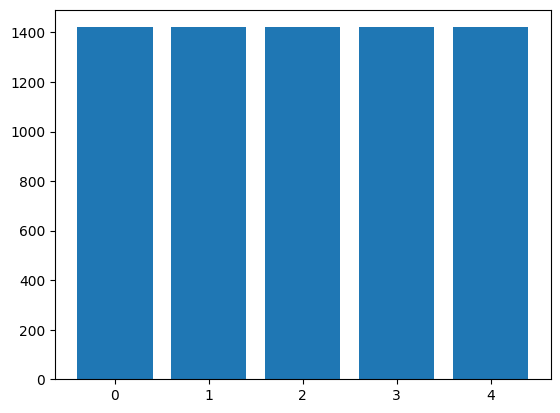

In [11]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import matplotlib.pyplot as plt

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X)

# Define the unique classes present in your labels
unique_classes = set(y)  # Get the unique classes in the original labels

# Print or check the unique classes
print("Unique Classes:", unique_classes)

# Apply RandomUnderSampler to undersample the majority class
undersample = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersample.fit_resample(X_tfidf, y)

# Summarize distribution
counter = Counter(y_resampled)
for k, v in counter.items():
    per = v / len(y_resampled) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

# Plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()


### Model with LogisticRegression classifier, TF-IDF vectorizer and RandomUnderSampler 

In [10]:
from imblearn.under_sampling import RandomUnderSampler

# instantiate the Model class with text and labels (X and y), a logistic regression model and a tfidf vectorizer
model_clf = Improved_model(X, y, LogisticRegression(class_weight='balanced', solver='liblinear'), TfidfVectorizer(preprocessor=preprocess_text),RandomUnderSampler(random_state=42), random_seed=42, test_size=0.2)

# fit the model
model_clf.fit()

# predict and generate classification report
model_clf.report(class_labels)

              precision    recall  f1-score   support

      1 star       0.59      0.77      0.67       292
     2 stars       0.36      0.41      0.39       333
     3 stars       0.36      0.46      0.40       432
     4 stars       0.54      0.44      0.49      1252
     5 stars       0.75      0.74      0.74      1790

    accuracy                           0.59      4099
   macro avg       0.52      0.57      0.54      4099
weighted avg       0.60      0.59      0.60      4099



## 4. Hyperparameter tuning, grid search, random search

We try to tune 'class_weight' parameter, by putting some weights to each class after analysing the dataset in notebook 1, class 4 being 3 times class 2 and class 5 being 5 times class 2.

In [25]:
from sklearn.model_selection import GridSearchCV

# Parameters to tune
param_grid = {
    'Model_Architecture__class_weight': [None, 'balanced', {0: 1, 1: 1, 2: 1, 3: 3, 4: 5}]
}

# Instantiate the Model class with text and labels
model_clf = Improved_model(X, y, SVC(), TfidfVectorizer(preprocessor=preprocess_text), SMOTE(), random_seed=42, test_size=0.2)

# Create a pipeline for the model
pipeline_model = Pipeline([
    ("Vectorizer", model_clf.vectorizer),
    ("Model_Architecture", model_clf.model_instance)
])

# Create GridSearchCV
grid_search = GridSearchCV(estimator=pipeline_model, param_grid=param_grid, scoring='accuracy', cv=5)

# Fit the model with GridSearch
grid_search.fit(model_clf.X_train, model_clf.y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Predict and generate a classification report with the best model
y_pred = grid_search.predict(model_clf.X_test)
print(classification_report(model_clf.y_test, y_pred, target_names=class_labels))


## Testing hyperparameter with LogisticRegression

### Tune class_weight parameter

In [ ]:
# Parameters to tune
param_grid = {
    'Model_Architecture__class_weight': [None, 'balanced', {0: 1, 1: 1, 2: 1, 3: 3, 4: 5}]
}

In [22]:
from sklearn.model_selection import GridSearchCV

# Instantiate the Model class with text and labels
model_clf = Improved_model(X, y, LogisticRegression(), TfidfVectorizer(preprocessor=preprocess_text), SMOTE(), random_seed=42, test_size=0.2)

# Create a pipeline for the model
pipeline_model = Pipeline([
    ("Vectorizer", model_clf.vectorizer),
    ("Model_Architecture", model_clf.model_instance)
])

# Create GridSearchCV
grid_search = GridSearchCV(estimator=pipeline_model, param_grid=param_grid, scoring='accuracy', cv=5)

# Fit the model with GridSearch
grid_search.fit(model_clf.X_train, model_clf.y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Predict and generate a classification report with the best model
y_pred = grid_search.predict(model_clf.X_test)
print(classification_report(model_clf.y_test, y_pred, target_names=class_labels))

/Users/mac/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/mac/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/U

Best Parameters: {'Model_Architecture__class_weight': None}
              precision    recall  f1-score   support

      1 star       0.78      0.61      0.68       292
     2 stars       0.49      0.39      0.44       333
     3 stars       0.48      0.25      0.33       432
     4 stars       0.55      0.51      0.53      1252
     5 stars       0.69      0.86      0.77      1790

    accuracy                           0.63      4099
   macro avg       0.60      0.52      0.55      4099
weighted avg       0.62      0.63      0.62      4099



### Tune 'C' parameter

In [23]:
# Parameters to tune
param_grid = {
    'Model_Architecture__C': [0.1, 1, 10, 100],
}

In [24]:
from sklearn.model_selection import GridSearchCV

# Instantiate the Model class with text and labels
model_clf = Improved_model(X, y, LogisticRegression(), TfidfVectorizer(preprocessor=preprocess_text), SMOTE(), random_seed=42, test_size=0.2)

# Create a pipeline for the model
pipeline_model = Pipeline([
    ("Vectorizer", model_clf.vectorizer),
    ("Model_Architecture", model_clf.model_instance)
])

# Create GridSearchCV
grid_search = GridSearchCV(estimator=pipeline_model, param_grid=param_grid, scoring='accuracy', cv=5)

# Fit the model with GridSearch
grid_search.fit(model_clf.X_train, model_clf.y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Predict and generate a classification report with the best model
y_pred = grid_search.predict(model_clf.X_test)
print(classification_report(model_clf.y_test, y_pred, target_names=class_labels))

/Users/mac/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/mac/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/U

Best Parameters: {'Model_Architecture__C': 1}
              precision    recall  f1-score   support

      1 star       0.78      0.61      0.68       292
     2 stars       0.49      0.39      0.44       333
     3 stars       0.48      0.25      0.33       432
     4 stars       0.55      0.51      0.53      1252
     5 stars       0.69      0.86      0.77      1790

    accuracy                           0.63      4099
   macro avg       0.60      0.52      0.55      4099
weighted avg       0.62      0.63      0.62      4099



In conclusion, while the SVM classifier exhibited a significantly prolonged execution time, various parameter adjustments were tested with Logistic Regression. Despite these efforts, the model consistently yielded an accuracy of 0.63. Surprisingly, the unaltered Support Vector Classifier (SVC) without any specific parameter tuning outperformed the Logistic Regression model, achieving a slightly higher accuracy of 0.64. This unexpected outcome suggests that, for this particular dataset, the default configuration of the SVC model may be more suitable and efficient than intricate parameter tuning.